In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy.random import multivariate_normal
from scipy.stats import gaussian_kde


def full_workflow(df, n_components=2, show_pca=False, show_functions=False, 
                  periodic=True, show_ci=False, show_latent=False, show_loss=False,
                  n_samples=100000, save_ci_csv=None, ss_theta=None):
    """
    Given the original dataset, this applies the full workflow
    OPTIONS:
        - show_pca (bool): Shows the PCA reduction of the zs... this is good to determine how many components to keep
        - n_components (int): Number of components to keep, set this after analyzing the PCA
        - show_functions (bool): Shows the true alpha and k functions as well as the sampled ones
        - show_ci (bool): Shows the nice confidence interval of the alpha-k functions with the true overlayed
        - save_ci_csv (str): If not None, will save the values of the mean, lower and upper 95%'s to a csv
        - show_latent (bool): Shows the distributions of the latent space and the samples overlaying
        - show_loss (bool): This simply plots a scatter of the samples and the loss accrued fitting them
        - ss_theta (int): If not None, this generates a strength surface at the specified angle from the sampled alpha-k functions
    """

    # to get a gague of how good the minimization was for this dataset (and maybe remove some outliers?)
    if show_loss:
        plot_loss_data(df, "Total Loss")

    if "Defect Type" in df.columns:
        zs = df.drop(columns=["Defect Type", "Defect Random Seed", "Total Loss", "RMSE"])
    else:
        zs = df.drop(columns=["Defect Random Seed", "Total Loss", "RMSE"])
    scaler = StandardScaler()  # define scaler
    z_scaled = scaler.fit_transform(zs)  # scale z data
    z_scaled = zs
    if show_pca:
        display_pca(z_scaled, threshold=[0.999, 0.9999, 0.99999])
        return
    
    # apply pca, fit gaussian, sample, apply inverse pca
    z_sampled_scaled = fit_latent_density(z_scaled, n_components, n_samples, show_latent_space=show_latent)
    # print(z_sampled_scaled[42])

    # inverse standardization (back to physical coefficient scale)
    samples_z = scaler.inverse_transform(z_sampled_scaled)
    print(samples_z[88])

    if show_functions:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        plot_alpha_k(zs, axs[:, 0], label='true', periodic=periodic)
        plot_alpha_k(samples_z, axs[:, 1], n_samples=min(n_samples, 1000), label='generated', periodic=periodic)
        plt.show()

    if show_ci:
        plot_ci(zs, samples_z, periodic, title="Double Vacancies", save_csv=save_ci_csv)
    
    if ss_theta is not None:
        samples = samples_z.to_numpy() if isinstance(samples_z, pd.DataFrame) else np.asarray(samples_z)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axhline(0, color='black', linewidth=1)
        ax.axvline(0, color='black', linewidth=1)
        for i in range(min(len(samples), 1000)):
            a, k = get_alpha_k(samples[i], ss_theta, periodic=False)
            plot_strength_surface(ax, a, k)
        ax.set_title(f"MX Artificial Strength Surfaces: θ={ss_theta}")
        ax.set_xlabel(r"$\sigma_1$")
        ax.set_ylabel(r"$\sigma_2$")
        plt.show()

def overlay_cis():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plot_given_ci(axs, pd.read_csv("stats_sv.csv"), 'red', 'SV')
    plot_given_ci(axs, pd.read_csv("stats_dv.csv"), 'blue', 'DV')
    plot_given_ci(axs, pd.read_csv("stats_mx.csv"), 'green', 'SV+DV')

    axs[0].set_title("α(θ) Statistical Analysis")
    axs[0].set_xlabel("θ (deg)")
    axs[0].set_ylabel("α")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title("k(θ) Statistical Analysis")
    axs[1].set_xlabel("θ (deg)")
    axs[1].set_ylabel("k")
    axs[1].legend()
    axs[1].grid(True)

    fig.tight_layout()
    plt.show()


def plot_strength_surface(ax, a, k, min_strength=-20, max_strength=130, color='k', alpha=0.07):
    grid = np.linspace(min_strength, max_strength, 600)
    sig1, sig2 = np.meshgrid(grid, grid)
    sig3 = np.zeros_like(sig1)
    i1 = sig1 + sig2 + sig3
    j2 = (sig1**2 + sig2**2 + sig3**2 - sig1*sig2 - sig2*sig3 - sig3*sig1) / 3.0
    F = np.sqrt(j2) + a * i1 - k
    ax.contour(sig1, sig2, F, levels=[0], linewidths=2, colors=color, alpha=alpha)  # F=0 curve


def display_pca(z_scaled, threshold=0.999):
    """This applies pca to the scaled zs dataset and shows the eigenvalue decay (so you can choose how many components you want to keep)"""
    pca = PCA()
    z_pca = pca.fit_transform(z_scaled)

    np.set_printoptions(precision=5, suppress=True)

    y = (1 - np.cumsum(pca.explained_variance_ratio_)) / np.cumsum(pca.explained_variance_ratio_)
    print('Fraction of total variance explained when using k components:\n', np.cumsum(pca.explained_variance_ratio_))
    print('Ratio of unexplained to explained variance after keeping k components:\n', y)
    fig, ax = plt.subplots(figsize=(8, 6))
    if isinstance(threshold, int):
        threshold = [threshold]
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = [item['color'] for item in list(color_cycle) if 'color' in item]
    for i, thresh in enumerate(threshold):
        suggested_idx = [idx for idx, value in enumerate(np.cumsum(pca.explained_variance_ratio_)) if value > thresh]
        suggested_dims = suggested_idx[0] + 1
        print(f"For a threshold of {thresh*100:.8g}%, you should choose {suggested_dims} dimensions.")
        ax.axvline(x=suggested_dims, ymin=0, ymax=1, color=colors[i], lw=1.5, linestyle='dashed', label=f'threshold={thresh*100:.8g}%')

    ax.plot(range(1, len(pca.explained_variance_)+1), y, lw=2, marker='o', c='k')
    ax.set_xlabel('Number of Principal Components')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_yscale('log')
    ax.set_ylabel('Cumulative Explained Variance (logscale)')
    ax.set_title('PCA Explained Variance')
    ax.grid(True)
    ax.legend()
    plt.show()


def fit_latent_density(z_scaled, n_components, n_samples, print_eigs=False, show_latent_space=False):
    """This applies pca on the dataset (should be scaled) and keeps specified number of components. Then it fits a 
    multivariate gaussian to the latent dataset, samples from it however many times you want, then applies inverse 
    pca and returns the samples (still scaled)"""
    pca = PCA(n_components=n_components)
    z_pca = pca.fit_transform(z_scaled)

    # print eigenvalues and explained variance if we want
    if print_eigs:
        print("Eigenvalues:", pca.explained_variance_)
        print("Explained variance ratio:", pca.explained_variance_ratio_)

    # now fit MV normal in latent space:
    mu = z_pca.mean(axis=0)
    Sigma = np.cov(z_pca, rowvar=False)
    np.random.seed(42)
    samples_pca = multivariate_normal(mu, Sigma, size=n_samples)
    # inverse PCA transform (back to standardized space)
    samples_scaled = pca.inverse_transform(samples_pca)

    if show_latent_space:
        max_samples = 1000
        plot_latent_space(z_pca, samples_pca[:min(len(samples_pca), max_samples)])

    return samples_scaled


def plot_alpha_k(samples, axs, periodic, n_samples=None, label='', return_params=False):
    """Plots the alphas and ks as functions of theta for all of the samples given. Must give axs which is len = 2 (one for alpha and one for k)"""
    # handle if samples is a pandas df
    samples = samples.to_numpy() if isinstance(samples, pd.DataFrame) else np.asarray(samples)

    def get_color(value, normalization, black='true'):
        if black:
            return 'k'
        cmap = plt.get_cmap('rainbow')   # or 'jet', 'turbo', 'plasma', etc.
        return cmap(value / normalization)

    theta = np.linspace(0, 90, 200)
    if n_samples is None:
        n_samples = len(samples)

    if return_params:
        all_alphas = np.empty((n_samples, len(theta)))
        all_ks = np.empty((n_samples, len(theta)))
    
    low_k = 100
    low_k_idx = 0

    for i in range(n_samples):  # plot samples
        alpha, k = get_alpha_k(samples[i, :], theta, 2, periodic=periodic)
        if k[-1] < low_k:
            low_k = k[-1]
            low_k_idx = i


        axs[0].plot(theta, alpha, c=get_color(i, n_samples, black=True), alpha=0.1)
        axs[1].plot(theta, k, c=get_color(i, n_samples, black=True), alpha=0.1)
        if return_params:
            all_alphas[i] = alpha
            all_ks[i] = k

    alpha, k = get_alpha_k(samples[low_k_idx, :], theta, 2, periodic=periodic)
    axs[0].plot(theta, alpha, c='r', alpha=0.8)
    axs[1].plot(theta, k, c='r', alpha=0.8)

    print(samples[low_k_idx, :])
    print(low_k_idx)
    
    axs[0].set_xlabel("θ")
    axs[0].set_ylabel("α value")
    axs[0].set_title(f"{label.capitalize()} α(θ)")
    axs[0].set_ylim(-0.2, 0.3)
    axs[1].set_xlabel("θ")
    axs[1].set_ylabel("k value")
    axs[1].set_title(f"{label.capitalize()} k(θ)")
    axs[1].set_ylim(20, 70)

    if return_params:
        return all_alphas, all_ks


def get_alpha_k(params, theta, return_k=True, periodic=True):
    if periodic:
        omega = 2 * np.pi * theta / 60
    else:
        omega = 2 * np.pi * theta / 180
    
    # infer N from length of data
    N = int((len(params) - 2) / 4)

    z_alpha = params[0]
    z_k = params[2*N+1]

    for m in range(1, N + 1):
        cos_coeff_a = params[2 * m - 1]
        sin_coeff_a = params[2 * m]
        z_alpha += cos_coeff_a * np.cos(m * omega) + sin_coeff_a * np.sin(m * omega)
        if return_k:
            cos_coeff_k = params[(2*N+1)+(2 * m - 1)]
            sin_coeff_k = params[(2*N+1)+(2 * m)]
            z_k += cos_coeff_k * np.cos(m * omega) + sin_coeff_k * np.sin(m * omega)
    
    # once we have the value of z_alpha and z_k, we must transform back to alpha and k:
    def softplus(z):
        return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0)

    alpha = -np.sqrt(3) / 6 + softplus(z_alpha)
    if return_k:
        k = softplus(z_k)
        return alpha, k
    else:
        return alpha


def plot_ci(true_z, samples_z, periodic, title=None, save_csv=None):
    theta = np.linspace(0, 90, 200)
    alphas = []
    ks = []

    n_samples = samples_z.shape[0]

    # preallocate arrays
    alphas = np.empty((n_samples, len(theta)))
    ks = np.empty((n_samples, len(theta)))

    # loop, but fill directly into arrays
    for i in range(n_samples):
        alpha, k = get_alpha_k(samples_z[i, :], theta, periodic=periodic)
        alphas[i, :] = alpha
        ks[i, :] = k

    alpha_mean = np.mean(alphas, axis=0)
    alpha_lower = np.percentile(alphas, 2.5, axis=0)
    alpha_upper = np.percentile(alphas, 97.5, axis=0)

    k_mean = np.mean(ks, axis=0)
    k_lower = np.percentile(ks, 2.5, axis=0)
    k_upper = np.percentile(ks, 97.5, axis=0)

    print(f"K mean at theta=0: {k_mean[0]}. at theta=90: {k_mean[-1]}")
    print(f"K lower 95% bound at theta=0: {k_lower[0]} at theta=90: {k_lower[-1]}")
    print(f"K upper 95% bound at theta=0: {k_upper[0]} at theta=90: {k_upper[-1]}")

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    all_real_alphas, all_real_ks = plot_alpha_k(true_z, axs, label='true', periodic=periodic, return_params=True)  # plot the true z's on the ax
    # α(θ)
    axs[0].fill_between(theta, alpha_lower, alpha_upper, color='lightblue', alpha=0.6, label='95% CI')
    axs[0].plot(theta, np.mean(all_real_alphas, axis=0), color='black', linewidth=3, label='True Mean')
    axs[0].plot(theta, alpha_mean, color='gold', linewidth=2, label='Sample Mean', linestyle='--')
    axs[0].plot([], [], color='k', alpha=0.1, label='True Data')  # for the label
    axs[0].set_title("α(θ): True vs Sampled 95% CI")
    axs[0].set_xlabel("θ (deg)")
    axs[0].set_ylabel("α")
    axs[0].legend()
    axs[0].grid(True)

    # k(θ)
    axs[1].fill_between(theta, k_lower, k_upper, color='lightblue', alpha=0.8, label='95% CI')
    axs[1].plot(theta, np.mean(all_real_ks, axis=0), color='black', linewidth=3, label='True Mean')
    axs[1].plot(theta, k_mean, color='gold', linewidth=2, label='Sample Mean', linestyle='--')
    axs[1].plot([], [], color='k', alpha=0.1, label='True Data')
    axs[1].set_title("k(θ): True vs Sampled 95% CI")
    axs[1].set_xlabel("θ (deg)")
    axs[1].set_ylabel("k")
    axs[1].legend()
    axs[1].grid(True)

    if title is not None:
        fig.suptitle(title)
    
    if save_csv is not None:
        save_df = pd.DataFrame(columns=['theta', 'a mean', 'a lower 95', 'a upper 95', 'k mean', 'k lower 95', 'k upper 95'])
        save_df['theta'] = theta
        save_df['a mean'] = alpha_mean
        save_df['a lower 95'] = alpha_lower
        save_df['a upper 95'] = alpha_upper
        save_df['k mean'] = k_mean
        save_df['k lower 95'] = k_lower
        save_df['k upper 95'] = k_upper
        save_df.to_csv(f'{save_csv}', index=False)

    plt.tight_layout()
    plt.show()


def plot_latent_space(latent_real, latent_sampled, bandwidth='scott', resolution=200, scatter_alpha=0.2, scatter_size=4):
    n_latent = latent_real.shape[1]
    fig, axs = plt.subplots(n_latent, n_latent, figsize=(2.5 * n_latent, 2.5 * n_latent))

    max_val = max(np.max(latent_sampled), np.max(latent_real))
    max_val = 15
    min_val = -15

    for i in range(n_latent):
        for j in range(n_latent):
            ax = axs[i, j]

            if i == j:
                # --- 1D KDE on diagonal ---
                x = latent_real[:, i]
                kde = gaussian_kde(x, bw_method=bandwidth)
                xs = np.linspace(min_val, max_val, resolution)
                ys = kde(xs)
                ax.plot(xs, ys, color='blue', lw=2)
                ax.fill_between(xs, ys, color='blue', alpha=0.3)

                # overlay histogram of sampled data
                x_samp = latent_sampled[:, i]
                kde_samp = gaussian_kde(x_samp, bw_method=bandwidth)
                ax.plot(xs, kde_samp(xs), color='k', lw=2)
                ax.fill_between(xs, kde_samp(xs), color='k', alpha=0.3)
            else:
                # --- 2D KDE on off-diagonals ---
                x = latent_real[:, j]
                y = latent_real[:, i]

                # max_val = max(np.max(latent_real[:, j]), np.max(latent_real[:, i]))
                # min_val = min(np.min(latent_real[:, j]), np.min(latent_real[:, i]))
                # print(round(np.mean(x), 4), round(np.mean(y), 4))
                # print(round(np.std(x), 4), round(np.std(y), 4))
                kde = gaussian_kde(np.vstack([x, y]), bw_method=bandwidth)

                X, Y = np.meshgrid(np.linspace(min_val, max_val, resolution), np.linspace(min_val, max_val, resolution))
                Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

                # plot KDE heatmap
                ax.imshow(Z, extent=[min_val, max_val, min_val, max_val], origin='lower', cmap="plasma", aspect='auto', alpha=0.9)
                # overlay sampled scatter points
                ax.scatter(latent_sampled[:, j], latent_sampled[:, i], color='k', s=scatter_size, alpha=scatter_alpha)
                # ax.axvline(0, lw=0.8, color='white', alpha=0.6)
                # ax.axhline(0, lw=0.8, color='white', alpha=0.6)
                # ax.scatter(x[7], y[7], color='g', s=2, alpha=0.5)
                # ax.scatter(latent_sampled[22, j], latent_sampled[22, i], color='r', s=2, alpha=0.5)

            # axis labels
            if i == n_latent - 1:
                ax.set_xlabel(f"Latent {j+1}")
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(f"Latent {i+1}")
            else:
                ax.set_yticks([])

    plt.tight_layout()
    plt.suptitle("Joint KDE (real) + Sample Scatter (latent space)", y=1.02, fontsize=14)
    plt.show()


def plot_loss_data(df_params, loss_measure):
    fig, ax = plt.subplots(figsize=(8, 8))

    if "Defect Type" in df_params.columns:
        unique_types = df_params["Defect Type"].unique()
        color_map = {t: c for t, c in zip(unique_types, plt.cm.tab10.colors)}
        # Map to colors
        colors = df_params["Defect Type"].map(color_map)
    else:
        colors='k'

    ax.set_title("Error from minimization")

    ax.scatter(df_params["Defect Random Seed"], df_params[loss_measure], c=colors)
    ax.set_xlabel("Defect Random Seed")
    ax.set_ylabel(loss_measure)

    # Add legend if there are multiple different defect types
    if "Defect Type" in df_params.columns:
        for defect_type, color in color_map.items():
            ax.scatter([], [], color=color, label=defect_type)
        ax.legend(title="Defect Type")

    ax.grid()
    fig.tight_layout()
    plt.show()


def plot_given_ci(axs, df, col, lab):
    axs[0].plot(df["theta"], df["a mean"], lw=3, color=col, label=f'{lab} Mean')
    axs[0].plot(df["theta"], df["a lower 95"], lw=2, color=col, linestyle='dashed', label=f'{lab} CI')
    axs[0].plot(df["theta"], df["a upper 95"], lw=2, color=col, linestyle='dashed')

    axs[1].plot(df["theta"], df["k mean"], lw=3, color=col, label=f'{lab} Mean')
    axs[1].plot(df["theta"], df["k lower 95"], lw=2, color=col, linestyle='dashed', label=f'{lab} CI')
    axs[1].plot(df["theta"], df["k upper 95"], lw=2, color=col, linestyle='dashed')


In [33]:
n_components = 18
n_samples = 100000

df = pd.read_csv("z_np_dv4.csv")
# df = pd.read_csv("z_dv_no_outliers.csv")

if "Defect Type" in df.columns:
    zs = df.drop(columns=["Defect Type", "Defect Random Seed", "Total Loss", "RMSE"]).to_numpy()
else:
    zs = df.drop(columns=["Defect Random Seed", "Total Loss", "RMSE"]).to_numpy()

# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer(output_distribution="normal", random_state=42)
# zs_q = qt.fit_transform(zs)

# print(zs.shape)
scaler = StandardScaler()  # define scaler
z_scaled = scaler.fit_transform(zs)  # scale z data
# z_scaled = zs

pca = PCA(n_components=n_components)
z_pca = pca.fit_transform(z_scaled)

# print(pca.components_)
# print(z_pca[0])

# pd.DataFrame(z_pca).to_csv('dv_latent.csv', index=False)

rng = np.random.default_rng(42)

################### GAUSSIAN
mu = z_pca.mean(axis=0)
print("Original:")
Sigma = np.cov(zs, rowvar=False)
print(Sigma[:4, :4])
print("Scaled:")
Sigma = np.cov(z_scaled, rowvar=False)
print(Sigma[:4, :4])

# pd.DataFrame(Sigma).to_csv('dv_covariance.csv', index=False)

np.random.seed(42)
samples_pca = multivariate_normal(mu, Sigma, size=n_samples)

################### GAUSSIAN MIXTURE
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=3, covariance_type="full", reg_covar=1e-4, random_state=42)
# gmm.fit(z_pca)
# samples_pca, component_ids = gmm.sample(n_samples=5000)

################### KDE
# kde = gaussian_kde(z_pca.T, bw_method=0.5)
# samples_pca = kde.resample(5000).T

################### BAYESIAN GAUSSIAN MIXTURE
# from sklearn.mixture import BayesianGaussianMixture
# bgmm = BayesianGaussianMixture(
#     n_components=10,                      # upper bound (it'll use fewer automatically)
#     covariance_type='full',               # 'tied' or 'diag' can stabilize further
#     weight_concentration_prior_type='dirichlet_process',  # encourages sparse components
#     weight_concentration_prior=0.5,       # smaller = fewer active components
#     reg_covar=1e-3,                       # slight regularization for stability
#     max_iter=1000,
#     random_state=42
# )
# bgmm.fit(z_pca)
# samples_pca, comp_ids = bgmm.sample(n_samples=5000)

################### FACTOR ANALYSIS
# from sklearn.decomposition import FactorAnalysis
# q = max(2, min(6, z_pca.shape[1] // 2))   # small latent, tune by CV
# fa = FactorAnalysis(n_components=q, random_state=42)
# fa.fit(z_pca)

# # sample: f ~ N(0, I_q), ε ~ N(0, Ψ)
# rng = np.random.default_rng(42)
# f = rng.standard_normal((n_samples, q))
# eps = rng.standard_normal((n_samples, z_pca.shape[1])) * np.sqrt(fa.noise_variance_)
# samples_pca = f @ fa.components_ + fa.mean_ + eps

################### STUDENTS T DISTRIBUTION
# from scipy.stats import multivariate_t
# mu = np.mean(z_pca, axis=0)
# Sigma = np.cov(z_pca, rowvar=False)
# nu = 100  # degrees of freedom (tunable)
# samples_pca = multivariate_t(mu, Sigma, df=nu).rvs(size=5000, random_state=42)

################### LEDOIT-WOLF ESTIMATOR
# from sklearn.covariance import LedoitWolf
# lw = LedoitWolf().fit(z_pca)
# mu = z_pca.mean(axis=0)
# Sigma = lw.covariance_

# L = np.linalg.cholesky(Sigma + 1e-6*np.eye(Sigma.shape[0]))
# samples_pca = mu + rng.standard_normal((n_samples, Sigma.shape[0])) @ L.T

# inverse PCA transform (back to standardized space)
samples_scaled = pca.inverse_transform(samples_pca)
# print(samples_scaled.shape)

# print("Regular:")
# print(z_scaled)
# print("Inverse:")
# print(pca.inverse_transform(z_pca))

# inverse standardization (back to physical coefficient scale)
# samples_z = scaler.inverse_transform(samples_scaled)
# samples_z = samples_scaled
# print(samples_z.shape)

# samples_z = qt.inverse_transform(samples_z_q)


Original:
[[ 16.63409071   0.48055581 -28.93457489 -18.70633578]
 [  0.48055581   0.52542703  -0.8444796   -0.58279613]
 [-28.93457489  -0.8444796   50.39223281  32.59721088]
 [-18.70633578  -0.58279613  32.59721088  21.1120002 ]]
Scaled:
[[ 1.01        0.16417592 -1.0093857  -1.0081981 ]
 [ 0.16417592  1.01       -0.16575725 -0.17673279]
 [-1.0093857  -0.16575725  1.01        1.00938146]
 [-1.0081981  -0.17673279  1.00938146  1.01      ]]


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plot_alpha_k(zs, axs[:, 0], label='true', periodic=False)
plot_alpha_k(samples_z, axs[:, 1], n_samples=min(n_samples, 1000), label='generated', periodic=False)
plt.show()

In [50]:
n_components = 18
n_samples = 100000

df = pd.read_csv("z_np_dv4.csv")
# df = pd.read_csv("z_dv_no_outliers.csv")

if "Defect Type" in df.columns:
    zs = df.drop(columns=["Defect Type", "Defect Random Seed", "Total Loss", "RMSE"]).to_numpy()
else:
    zs = df.drop(columns=["Defect Random Seed", "Total Loss", "RMSE"]).to_numpy()

scaler = StandardScaler()  # define scaler
z_scaled = scaler.fit_transform(zs)  # scale z data
z_scaled = zs

pca = PCA(n_components=n_components, whiten=True)  # whiten=False is default
z_pca = pca.fit_transform(z_scaled)
print(z_pca)

rng = np.random.default_rng(42)

mu = z_pca.mean(axis=0)
Sigma = np.cov(z_pca, rowvar=False)
np.random.seed(42)
samples_pca = multivariate_normal(mu, Sigma, size=n_samples)

# inverse PCA transform (back to standardized space)
samples_scaled = pca.inverse_transform(samples_pca)

# inverse standardization (back to physical coefficient scale)
samples_z = scaler.inverse_transform(samples_scaled)
samples_z = samples_scaled



[[ 0.92425338 -1.02110723 -0.73584707 ...  1.52051103 -1.02149348
  -0.69635725]
 [-0.72228437 -0.66046427 -0.78052852 ...  0.31557523 -0.27663354
  -0.98037881]
 [-0.72550774  1.04992866  1.47753616 ...  0.21696903  1.27223204
  -1.14972763]
 ...
 [-0.71668239  0.52519678  0.88977782 ...  0.25711645  1.21622143
  -0.67403037]
 [-0.7099385   1.01954559  1.24245258 ... -0.6237468  -0.02138
   0.76640537]
 [ 0.17408459 -0.59786718 -1.20671126 ...  1.80945338  0.99744564
   1.42039012]]


In [ ]:
# X must be shape (n_features, n_samples) like MATLAB
X = zs.T
# 1. Compute mean
X_mean = X.mean(axis=1, keepdims=True)
# 2. Center
Xc = X - X_mean
# 3. Covariance (MATLAB's cov uses 1/(N-1))
C = np.cov(Xc)
# 4. Eigen decomposition
eigvals, V = np.linalg.eigh(C)
# 5. Sort in descending order (MATLAB’s eig does ascending)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
V = V[:, idx]
# 6. Fix sign ambiguity (like MATLAB)
# Make first component positive
for j in range(V.shape[1]):
    if V[0, j] < 0:
        V[:, j] *= -1
# 7. Whitening (MATLAB does D^{-1/2} * V' * Xc)
D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))
H = D_inv_sqrt @ V.T @ Xc   # shape = (n_features, n_samples)  # whitening
# H = V.T @ Xc  # No whitening
# 8. Reconstruction example (to verify)
X_recon = X_mean + V @ np.diag(np.sqrt(eigvals)) @ H
print(H)


[[-2.52785732e+02  1.97546675e+02  1.98428276e+02 ...  1.96014519e+02
   1.94170048e+02 -4.76125942e+01]
 [ 6.28454668e+01  4.06491931e+01 -6.46193219e+01 ... -3.23239675e+01
  -6.27493531e+01  3.67965682e+01]
 [-9.83356319e+00 -1.04306681e+01  1.97451967e+01 ...  1.18906315e+01
   1.66036346e+01 -1.61260020e+01]
 ...
 [ 1.47995421e-02  3.07157872e-03  2.11181805e-03 ...  2.50258345e-03
  -6.07109497e-03  1.76118954e-02]
 [-6.17205555e-03 -1.67147128e-03  7.68706601e-03 ...  7.34863888e-03
  -1.29182282e-04  6.02675314e-03]
 [ 4.05712985e-03  5.71190097e-03  6.69856326e-03 ...  3.92704742e-03
  -4.46524490e-03 -8.27550325e-03]]


In [51]:
from ipywidgets import interact, IntSlider, fixed, Checkbox

def plot_latent(var1, var2, marginals, real_data, sampled_data, varnames):
    if marginals:
        var2 = var1
    fig, ax = plt.subplots(figsize=(6, 6))
    if var1 == var2:
        # min_val = min(np.min(real_data[:, var1-1]), np.min(sampled_data[:, var1-1]))
        # max_val = max(np.max(real_data[:, var1-1]), np.max(sampled_data[:, var1-1]))
        min_val = np.min(real_data[:, var1-1]) - 1
        max_val = np.max(real_data[:, var1-1]) + 1
        kde_real = gaussian_kde(real_data[:, var1-1], bw_method=0.15)
        kde_samp = gaussian_kde(sampled_data[:, var1-1])
        xs = np.linspace(min_val, max_val, 200)
        density_real = kde_real(xs)
        density_samp = kde_samp(xs)
        ax.plot(xs, density_real, color='blue', lw=2, label='real')
        ax.plot(xs, density_samp, color='red', lw=2, label='sampled')
        ax.set_xlabel(f'{varnames} {var1}')
        ax.set_ylabel(f'Density')
    else:
        colors = np.linspace(0, 1, len(real_data))
        ax.scatter(sampled_data[:, var1-1], sampled_data[:, var2-1], c='r', label='sampled', alpha=0.1)
        ax.scatter(real_data[:, var1-1], real_data[:, var2-1], c='b', label='real')
        # plt.colorbar(ax.collections[0], ax=ax, label="Row index (0 = first, 1 = last)")
        # ax.scatter(real_data[54, var1-1], real_data[54, var2-1], c='k', label='54')
        # ax.scatter(real_data[79, var1-1], real_data[79, var2-1], c='k', label='79')
        # ax.scatter(real_data[38, var1-1], real_data[38, var2-1], c='g', label='38')  # sv true outlier
        # ax.scatter(real_data[7, var1-1], real_data[7, var2-1], c='g', label='7')  # dv true outlier
        # ax.scatter(sampled_data[380, var1-1], sampled_data[380, var2-1], c='k', label='380', alpha=1)
        ax.set_xlabel(f'{varnames} {var1}')
        ax.set_ylabel(f'{varnames} {var2}')
    ax.legend()
    plt.show()


var1_slider = IntSlider(description='x axis var', min=1, max=n_components, step=1, value=1)
var2_slider = IntSlider(description='y axis var', min=1, max=n_components, step=1, value=1)

scrub_marginals = Checkbox(value=False, description='View Marginals')
labels = 'PC'
# H.T
interact(plot_latent, var1=var1_slider, var2=var2_slider, marginals=scrub_marginals, real_data=fixed(z_pca),
         sampled_data=fixed(samples_pca), varnames=fixed(labels))

interactive(children=(IntSlider(value=1, description='x axis var', max=18, min=1), IntSlider(value=1, descript…

<function __main__.plot_latent(var1, var2, marginals, real_data, sampled_data, varnames)>

Shifted Theta such that Theta[new] = Theta[old] - Rotation Angle.


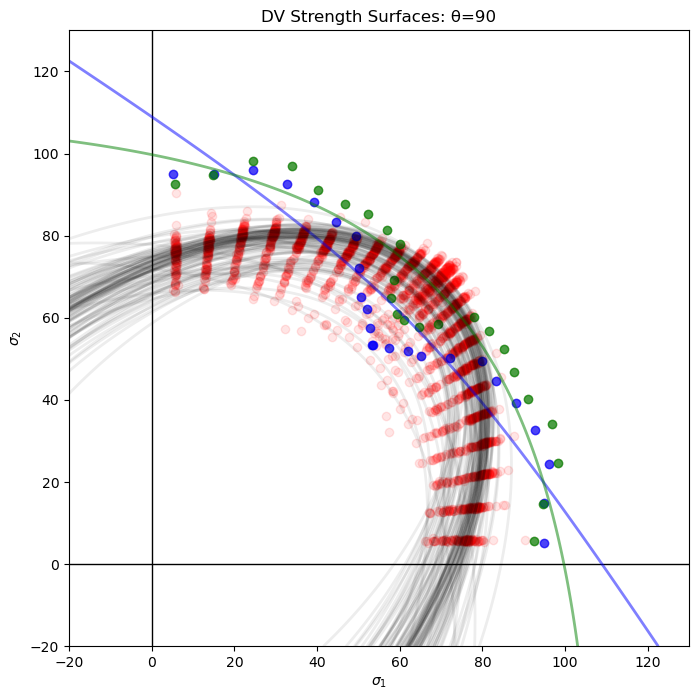

In [61]:
from filter_csv import filter_data
import local_config
samples_z = zs  ##################
ss_theta = 90

df = pd.read_csv(f"{local_config.DATA_DIR}/rotation_tests/all_simulations.csv")
filtered_df = filter_data(df, exact_filters={"Defects": '{"DV": 0.5}', "Theta Requested": 90}, flip_strengths=True, duplic_freq=(0, 91, 10), remove_dupes=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)
for i in range(min(len(samples_z), 500)):
    a, k = get_alpha_k(samples_z[i], ss_theta, periodic=False)
    if i == 54:
        plot_strength_surface(ax, a, k, color='b', alpha=0.5)
    elif i == 74:
        plot_strength_surface(ax, a, k, color='g', alpha=0.5)
    else:
        plot_strength_surface(ax, a, k)
# a, k = get_alpha_k(samples_z[54], ss_theta, periodic=False)
# plot_strength_surface(ax, a, k, color='r', alpha=1)
ax.scatter(filtered_df["Strength_1"], filtered_df["Strength_2"], c='r', alpha=0.1)
outliers54 = filtered_df[(filtered_df["Defect Random Seed"] == 54)]
outliers74 = filtered_df[(filtered_df["Defect Random Seed"] == 74)]
ax.scatter(outliers54["Strength_1"], outliers54["Strength_2"], c='b', alpha=0.7)
ax.scatter(outliers74["Strength_1"], outliers74["Strength_2"], c='g', alpha=0.7)


ax.set_title(f"DV Strength Surfaces: θ={ss_theta}")
ax.set_xlabel(r"$\sigma_1$")
ax.set_ylabel(r"$\sigma_2$")
plt.show()

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("z_np_dv4.csv")
if "Defect Type" in df.columns:
    zs = df.drop(columns=["Defect Type", "Defect Random Seed", "Total Loss", "RMSE"])
else:
    zs = df.drop(columns=["Defect Random Seed", "Total Loss", "RMSE"])

to_drop = []
for i, row in zs.iterrows():
    a, k = get_alpha_k(row, 90, periodic=False)
    if k > 90:
        to_drop.append(i)

df.drop(index=to_drop, inplace=True)

df.to_csv("z_dv_no_outliers.csv", index=False)

/tmp/ipykernel_132701/1374633957.py:227: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_alpha = params[0]
/tmp/ipykernel_132701/1374633957.py:228: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_k = params[2*N+1]
/tmp/ipykernel_132701/1374633957.py:231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cos_coeff_a = params[2 * m - 1]
/tmp/ipykernel_132701/1374633957.py:232: FutureWarning: Series.__getitem__ treating keys as positions i

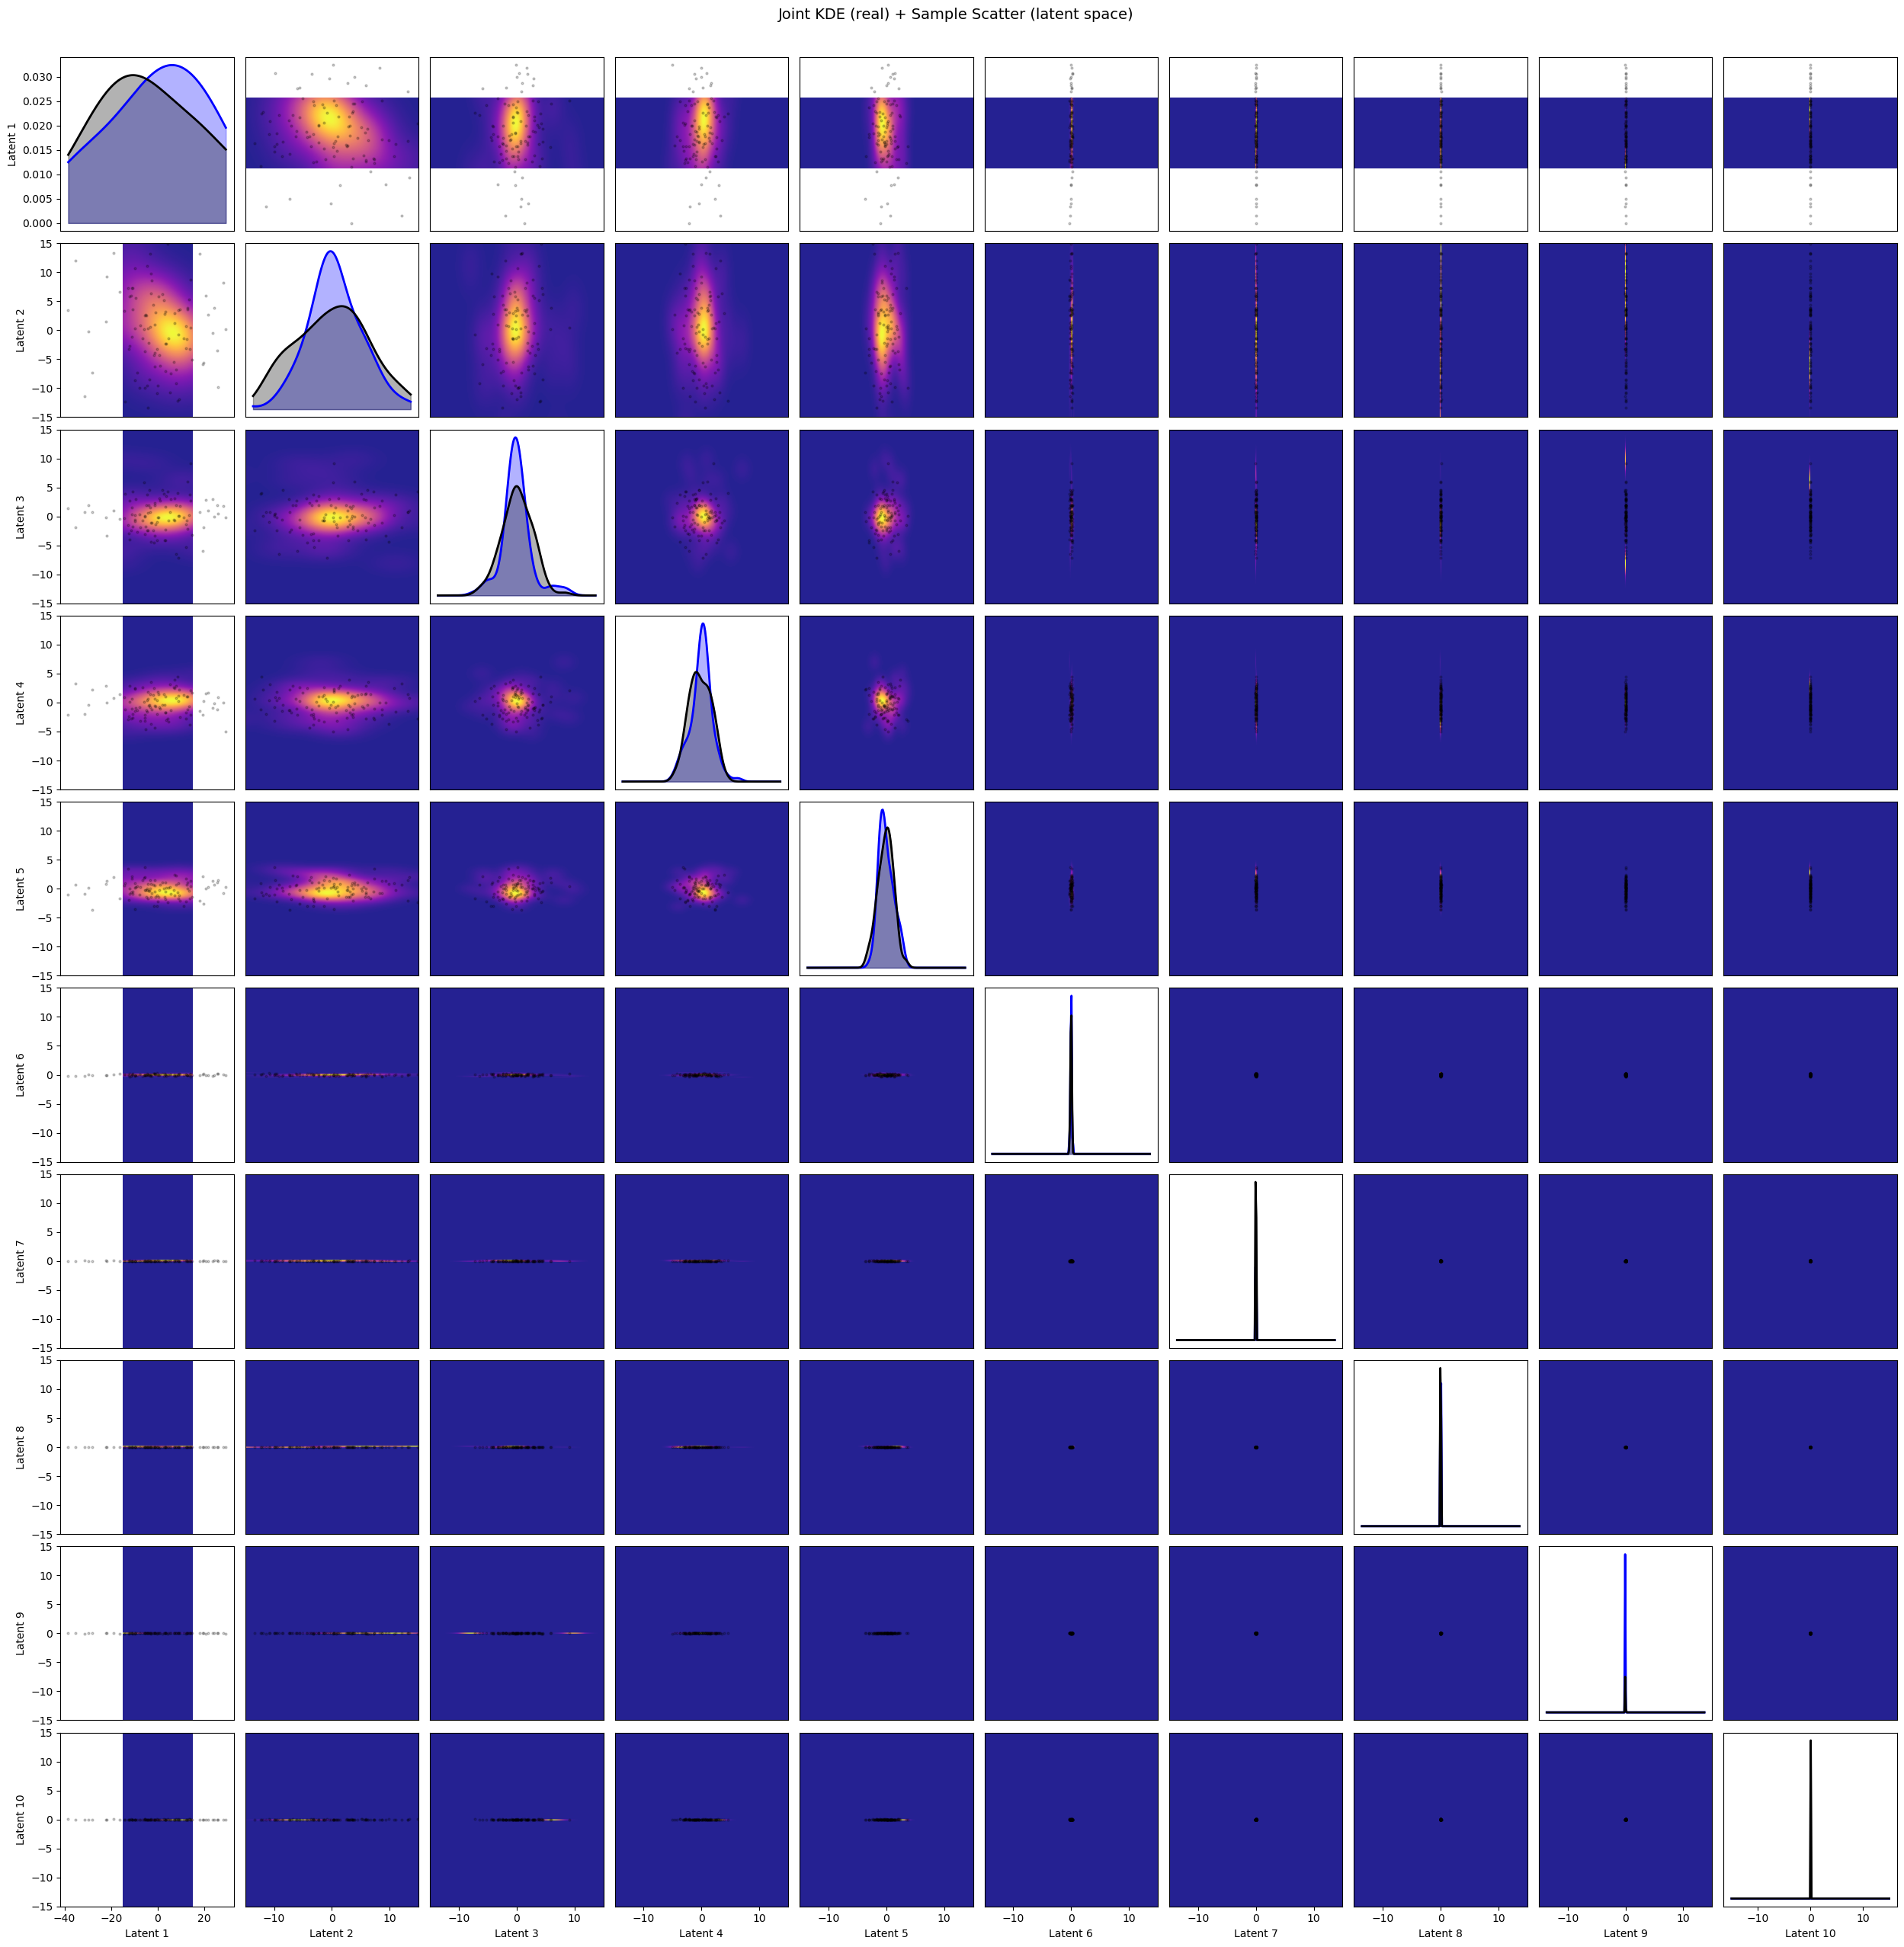

[-1.20855166e+00 -1.83780304e-01  1.94835712e-02  5.72631746e-02
  1.24826545e-01  5.74761251e+02 -1.23587883e+02 -2.62046706e+02
 -4.63800744e+01  4.75509906e+01]


In [15]:

df = pd.read_csv("z_np_dv2.csv")
# full_workflow(df, show_pca=True)
full_workflow(df, n_components=10, show_latent=True, periodic=False, n_samples=100)
# full_workflow(df, n_components=6, ss_theta=90, periodic=False)
# overlay_cis()


